# Lung Segmentation using CT Scans

We use a dataset comprising lung CT scans, exactly 45 scans, having varying number of slices for each, and the corresponding labels mark trachea, left and right lung which has been changed to just lungs. Our primary objective is to accurately segment the lungs.Our approach involves preprocessing steps, such as the removal of the trachea label and the amalgamation of left and right lung masks into a single label, followed by the application of various deep learning models to perform segmentation.

The project explores different model architectures and loss functions, fine-tuning them with a specific focus on achieving high accuracy in segmentation tasks. Our experimentation is driven by a dual objective: to develop a model that performs effectively on our dataset and added we also benchmark our best model against a state-of-the-art tool in the field, lungmask

## Initial Changes(Trachea label removal and Mask Amalgation)
For this we remove the trachea(5) label and combine the left(3) and right(4) lung masks into one label.

In [ ]:
import os
import nibabel as nib
import numpy as np

def process_labels(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith('.nii.gz'):
            file_path = os.path.join(input_folder, filename)
            label_file = nib.load(file_path)
            label_data = label_file.get_fdata()
            combined_label = np.where((label_data == 3) | (label_data == 4), 1, 0)

            new_label_file = nib.Nifti1Image(combined_label, label_file.affine)
            nib.save(new_label_file, os.path.join(output_folder, filename))

input_folder = 'labelsTr'
output_folder = '/home2/rhuthik.p/BioCliq/test'
process_labels(input_folder, output_folder)


From here on we will be using this as our lung masks

## Experimentation

We conduct a set of experiments to find the best model, which has been found to be Res18 BCE as shown

| Model         | Train  | validation | test   |
|---------------|--------|------------|--------|
| Res34 BCE     | 0.9828 | 0.9667     | 0.9560 |
| **Res18 BCE** | 0.9872 | 0.9444     | **0.9573** |
| Res18 Dice    | 0.9827 | 0.9325     | 0.9517 |
| Res18 focal   | 0.9780 | 0.9323     | 0.8559 |
| LungMask      | -      | -          | 0.9526 |


We experiment with different ResNet Based models and loss function variations, from experimentation I have found and fixed other parameters like epochs and learning rate as 20 and 0.0001

## Firstly importing the necessary libraries needed

In [ ]:
import gzip
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline
import os
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torch.nn.functional import pad

## Image Preprocessing
Doing mainly 2 preprocessing activities, which are :
### Intensity clipping
This basically limits our pixel intensity value range in image, in our case to (-1024,600), why? Through literature survey found that lung ct scans falls in this region

### Contrast Stretching
CS improves the contrast by stretching the range of intensity values. we use (-1350,150) again following our findings. But this has not been used in our experimentation and was added in case we needed


Now we load our dataset in the below class, here we do the above preprocessing and organise and sort the image and label paths.

In [2]:
class NiiDataset(Dataset):
    def __init__(self, images_dir, labels_dir, clip_range=(-1024, 600), 
                 contrast_range=(-1350, 150), contrast_stretch=False):

        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.clip_range = clip_range
        self.contrast_range = contrast_range
        self.contrast_stretch = contrast_stretch

        self.images = [os.path.join(images_dir, file) for file in os.listdir(images_dir)]
        self.labels = [os.path.join(labels_dir, file) for file in os.listdir(labels_dir)]
        self.images.sort()
        self.labels.sort()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label_path = self.labels[idx]
        image = nib.load(image_path).get_fdata()
        label = nib.load(label_path).get_fdata()
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0) 
        label = torch.tensor(label, dtype=torch.float32)

        return image, label

    def contrast_stretch_transform(self, image):
        min_val, max_val = self.contrast_range
        image = (image - image.min()) / (image.max() - image.min()) 
        image = image * (max_val - min_val) + min_val 
        return image

imagedata class is used to subdivide our datasets into chunks for testing,training and validating.

Here we also do reshaping and permuting so that we can give each slice as input.(H,W,D will be changed to D,H,W )

In [3]:
class imagedata(Dataset):
    def __init__(self, data, clip_range=(-1024, 600), 
                 contrast_range=(-1350, 150),indices = (0,36) ,contrast_stretch=False):
        # print("in init")
        self.clip_range = clip_range
        self.contrast_range = contrast_range
        self.contrast_stretch = contrast_stretch
        datapoints = []
        # print(len(datapoints))
        for i in range(indices[0],indices[1]):
            datapoints.append(data[i])
        self.images = []
        self.labels = []
        for i in range(len(datapoints)):
            imgs , labs = datapoints[i]
            # print(imgs.shape,labs.shape)
            imgsn = torch.permute(imgs.squeeze(0), (2, 0, 1))
            # print(imgsn.shape)
            labsn = torch.permute(labs, (2, 0, 1))
            # print(labsn.shape)
            for j in range(imgsn.shape[0]):
                self.images.append(imgsn[j])
                self.labels.append(labsn[j])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = image.clip(*self.clip_range)

        if self.contrast_stretch:
            image = self.contrast_stretch_transform(image)

        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  
        label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)

        return image, label

    def contrast_stretch_transform(self, image):
        min_val, max_val = self.contrast_range
        image = (image - image.min()) / (image.max() - image.min())  
        image = image * (max_val - min_val) + min_val  
        return image

Dice Score is used as our metrics for evaluation, since we deal with segmentation. It measures the overlap between predicted and actual segmentations. Here we define it

In [4]:
def dice_score(pred, target, epsilon=1e-6):
    pred = torch.sigmoid(pred)  # Apply sigmoid to get binary predictions
    pred = (pred > 0.5).float()  # Binarize predictions (thresholding at 0.5)

    intersection = (pred * target).sum(dim=[2, 3])  # Compute intersection
    union = pred.sum(dim=[2, 3]) + target.sum(dim=[2, 3])  # Compute union

    dice = (2. * intersection + epsilon) / (union + epsilon)  # Compute Dice score
    return dice.mean() 

## Model Training function
Here we encapsulate the training loop. It includes forward pass for predictions, loss calculation and backpropogation. Then we have a mechanism for tracking and saving the best model based on validation loss. And also a logging for later analysis, mainly the training and validation metrics.

In [14]:
import torch
from tqdm import trange, tqdm
import segmentation_models_pytorch as smp

def train_model(model, num_epochs, train_loader, valid_loader, device, loss_criterion, optimizer, dice_score_function, best_model_save_name, train_save_path, valid_save_path, dice_save_path):
    train_losses = []
    train_dice_scores = []
    valid_losses = []
    valid_dice_scores = []

    best_valid_loss = float('inf') 
    model.to(device)

    for epoch in trange(num_epochs):
        model.train()
        total_train_loss = 0
        total_train_dice = 0
        train_count = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            predictions = model(images)
            loss = loss_criterion(predictions, labels)
            dice_score_value = dice_score_function(predictions, labels).item()

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_train_dice += dice_score_value
            train_count += 1

        avg_train_loss = total_train_loss / train_count
        avg_train_dice = total_train_dice / train_count
        train_losses.append(avg_train_loss)
        train_dice_scores.append(avg_train_dice)

        # Validation phase
        model.eval()
        total_valid_loss = 0
        total_valid_dice = 0
        valid_count = 0

        with torch.no_grad():
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)

                predictions = model(images)
                loss = loss_criterion(predictions, labels)
                dice_score_value = dice_score_function(predictions, labels).item()

                total_valid_loss += loss.item()
                total_valid_dice += dice_score_value
                valid_count += 1

        avg_valid_loss = total_valid_loss / valid_count
        avg_valid_dice = total_valid_dice / valid_count
        valid_losses.append(avg_valid_loss)
        valid_dice_scores.append(avg_valid_dice)

        # Save model if validation loss improved
        if avg_valid_loss < best_valid_loss:
            best_valid_loss = avg_valid_loss
            torch.save(model.state_dict(), best_model_save_name)

        # Save metrics to files
        with open(train_save_path, 'a') as f:
            f.write(f"{avg_train_loss}\n")
        with open(valid_save_path, 'a') as f:
            f.write(f"{avg_valid_loss}\n")
        with open(dice_save_path, 'a') as f:
            f.write(f"{avg_train_dice}\n")

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Dice Score: {avg_train_dice:.4f}, "
              f"Validation Loss: {avg_valid_loss:.4f}, Validation Dice Score: {avg_valid_dice:.4f}")

    return train_losses, train_dice_scores, valid_losses, valid_dice_scores

## Plotting Functions for LOSS and DICE SCORE
plot_loss: Visualizes the training and validation loss over epochs, aiding in the identification of overfitting or underfitting.

plot_dice: Displays the Dice score over epochs, indicating the model's performance in segmentation tasks.

In [15]:
def plot_loss(train_save_path, valid_save_path):
    train_losses = []
    valid_losses = []

    with open(train_save_path, 'r') as f:
        for line in f:
            train_losses.append(float(line.strip()))

    with open(valid_save_path, 'r') as f:
        for line in f:
            valid_losses.append(float(line.strip()))

    plt.plot(train_losses, label='Training loss')
    plt.plot(valid_losses, label='Validation loss')
    plt.legend()
    plt.show()
    
def plot_dice(dice_save_path):
    train_dice_scores = []

    with open(dice_save_path, 'r') as f:
        for line in f:
            train_dice_scores.append(float(line.strip()))

    plt.plot(train_dice_scores, label='Training Dice score')
    plt.legend()
    plt.show()

## Model Evaluation Function
Here we compute the Dice score for each sample in test set and average them. A visualisation of the results is also done for qualitative analysis

In [16]:
def eval_model(model, data, device):
    model.eval()
    test_dice_scores = []
    results = []
    olabels = []
    with torch.no_grad():
        for images, labels in tqdm(data):
            images = images.to(device)
            labels = labels.to(device)
            predictions = model(images)
            results.append(predictions)
            olabels.append(labels)
            dice_score_value = dice_score(predictions, labels).item()
            test_dice_scores.append(dice_score_value)

    avg_test_dice_score = sum(test_dice_scores) / len(test_dice_scores)
    print(f'Average Test Dice Score: {avg_test_dice_score:.4f}')
    return results,olabels,test_dice_scores

In [17]:
def plot_results(result, label,batch,index):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(result[batch][index][0].detach().cpu().numpy() > 0.5,cmap='gray')
    ax[0].set_title('Prediction')
    ax[0].axis('off')
    ax[1].imshow(label[batch][index][0].detach().cpu().numpy(),cmap='gray')
    ax[1].set_title('Original Label')
    ax[1].axis('off')
    plt.show()

## Data Loading and Splitting
Here, we load the data using the previously defined classes and split it into training, validation, and test sets.We distribute them as 70:20:10 respectively

In [ ]:
batch_size = 14

dat = NiiDataset('/home2/rhuthik.p/BioCliq/imagesTr', '/home2/rhuthik.p/BioCliq/test')
train_data = imagedata(dat,indices = (0,31)) # 70%
valis_data = imagedata(dat,indices = (31,40)) # 20%
test_data = imagedata(dat,indices = (36,40)) #10%
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valis_data, batch_size=batch_size, shuffle=False)

In [13]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display

## Now we experiment with different models and its hyperparameters.
### Shared Parameters and Rationale
For all models, we use a learning rate of 0.0001 and train for 20 epochs. The choice of these parameters was determined through experimentation. A lower learning rate allows for more precise model updates, which is crucial in fine-tuning models with pretrained weights like ours. The pretrained ImageNet weights provide a strong foundation, as ImageNet encompasses a wide range of features. This pretraining helps in achieving better generalization when fine-tuning with our specific lung CT scan dataset.
### Our Best Model is ResUnet with resnet 18 architecure with an Average Test Dice Score: 0.9573
For our models , we have used pretrained weights from ImageNet which was trained on a vast amount of image dataset, which provides us a good base.
Then we finetune for our specific case here of lung segmentation.

## ResUnet with resnet 18 and BCE
* ResNet18 is chosen for its balance between performance and computational efficiency. It's a smaller and faster model compared to ResNet34, making it more suitable for deployment.
* BCEWithLogitsLoss is used, which combines a sigmoid layer with the binary cross-entropy loss. This loss function is suitable for binary classification tasks like ours, where each pixel is classified as lung or non-lung.
* The choice of ResNet18 was motivated by its superior performance in preliminary tests and its efficiency, making it suitable for practical applications. The initial encoder weights from ImageNet provide a robust starting point, as ImageNet-trained models capture a wide range of features that are beneficial for a variety of tasks.

## Training

In [19]:
num_epochs = 20
model = smp.Unet(
    encoder_name="resnet18",       # Choose encoder architecture
    encoder_weights="imagenet",    # Use pre-trained weights from ImageNet
    in_channels=1,                 # Number of input channels (1 for grayscale images)
    classes=1                      # Number of output classes (1 for binary segmentation)
)
loss_criterion = torch.nn.BCEWithLogitsLoss()
dice_score_function = dice_score
prefix = 'unet_'+str(num_epochs)+'_resnet18_1e-4_'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [28]:
train_losses, train_dice_scores, valid_losses, valid_dice_scores = train_model(model, num_epochs, train_loader, valid_loader, device, loss_criterion, optimizer, dice_score_function, prefix+ 'best_model.pth', prefix+'train_loss.txt',prefix+ 'valid_loss.txt', prefix+'dice_scores.txt')

  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_8339/2511421886.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
/tmp/ipykernel_8339/2511421886.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
  5%|▌         | 1/20 [02:45<52:20, 165.31s/it]

Epoch [1/20], Train Loss: 0.0982, Train Dice Score: 0.8921, Validation Loss: 0.0362, Validation Dice Score: 0.9185


 10%|█         | 2/20 [05:25<48:41, 162.29s/it]

Epoch [2/20], Train Loss: 0.0233, Train Dice Score: 0.9577, Validation Loss: 0.0201, Validation Dice Score: 0.9495


 15%|█▌        | 3/20 [08:07<45:59, 162.34s/it]

Epoch [3/20], Train Loss: 0.0124, Train Dice Score: 0.9649, Validation Loss: 0.0126, Validation Dice Score: 0.9478


 20%|██        | 4/20 [10:52<43:32, 163.25s/it]

Epoch [4/20], Train Loss: 0.0090, Train Dice Score: 0.9646, Validation Loss: 0.0126, Validation Dice Score: 0.9559


 25%|██▌       | 5/20 [13:33<40:35, 162.37s/it]

Epoch [5/20], Train Loss: 0.0062, Train Dice Score: 0.9774, Validation Loss: 0.0088, Validation Dice Score: 0.9509


 30%|███       | 6/20 [16:14<37:45, 161.80s/it]

Epoch [6/20], Train Loss: 0.0051, Train Dice Score: 0.9797, Validation Loss: 0.0077, Validation Dice Score: 0.9514


 35%|███▌      | 7/20 [18:52<34:48, 160.69s/it]

Epoch [7/20], Train Loss: 0.0045, Train Dice Score: 0.9811, Validation Loss: 0.0090, Validation Dice Score: 0.9487


 40%|████      | 8/20 [21:31<32:01, 160.10s/it]

Epoch [8/20], Train Loss: 0.0040, Train Dice Score: 0.9826, Validation Loss: 0.0115, Validation Dice Score: 0.9393


 45%|████▌     | 9/20 [24:09<29:14, 159.52s/it]

Epoch [9/20], Train Loss: 0.0064, Train Dice Score: 0.9641, Validation Loss: 0.0168, Validation Dice Score: 0.9142


 50%|█████     | 10/20 [26:47<26:31, 159.15s/it]

Epoch [10/20], Train Loss: 0.0046, Train Dice Score: 0.9713, Validation Loss: 0.0174, Validation Dice Score: 0.9333


 55%|█████▌    | 11/20 [29:26<23:52, 159.13s/it]

Epoch [11/20], Train Loss: 0.0037, Train Dice Score: 0.9802, Validation Loss: 0.0199, Validation Dice Score: 0.9388


 60%|██████    | 12/20 [32:06<21:14, 159.35s/it]

Epoch [12/20], Train Loss: 0.0034, Train Dice Score: 0.9828, Validation Loss: 0.0176, Validation Dice Score: 0.9462


 65%|██████▌   | 13/20 [34:45<18:33, 159.12s/it]

Epoch [13/20], Train Loss: 0.0032, Train Dice Score: 0.9844, Validation Loss: 0.0197, Validation Dice Score: 0.9360


 70%|███████   | 14/20 [37:23<15:53, 158.86s/it]

Epoch [14/20], Train Loss: 0.0031, Train Dice Score: 0.9848, Validation Loss: 0.0199, Validation Dice Score: 0.9336


 75%|███████▌  | 15/20 [40:01<13:13, 158.68s/it]

Epoch [15/20], Train Loss: 0.0030, Train Dice Score: 0.9852, Validation Loss: 0.0242, Validation Dice Score: 0.9294


 80%|████████  | 16/20 [42:40<10:34, 158.55s/it]

Epoch [16/20], Train Loss: 0.0030, Train Dice Score: 0.9847, Validation Loss: 0.0314, Validation Dice Score: 0.9086


 85%|████████▌ | 17/20 [45:18<07:55, 158.48s/it]

Epoch [17/20], Train Loss: 0.0058, Train Dice Score: 0.9632, Validation Loss: 0.0103, Validation Dice Score: 0.9360


 90%|█████████ | 18/20 [47:56<05:16, 158.45s/it]

Epoch [18/20], Train Loss: 0.0031, Train Dice Score: 0.9828, Validation Loss: 0.0113, Validation Dice Score: 0.9387


 95%|█████████▌| 19/20 [50:35<02:38, 158.41s/it]

Epoch [19/20], Train Loss: 0.0029, Train Dice Score: 0.9858, Validation Loss: 0.0149, Validation Dice Score: 0.9334


100%|██████████| 20/20 [53:13<00:00, 159.67s/it]

Epoch [20/20], Train Loss: 0.0028, Train Dice Score: 0.9872, Validation Loss: 0.0129, Validation Dice Score: 0.9444


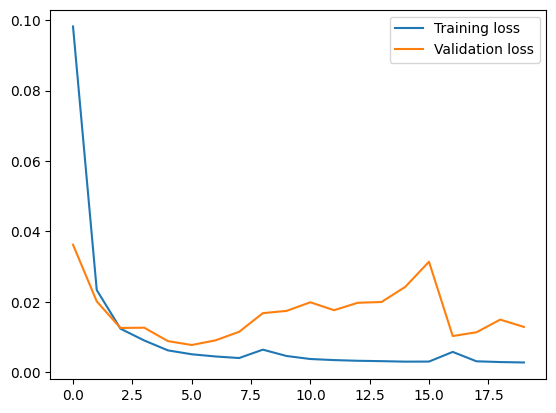

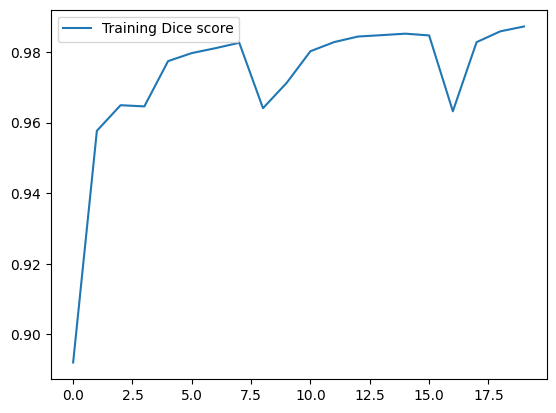

In [29]:
plot_loss(prefix+'train_loss.txt', prefix+'valid_loss.txt')
plot_dice(prefix+'dice_scores.txt')

## Evaluating

In [20]:
model_path = prefix+ 'best_model.pth' 
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)

In [21]:
res, lab, dice = eval_model(model, test_loader, device)

100%|██████████| 89/89 [00:08<00:00,  9.95it/s]

Average Test Dice Score: 0.9573


### To view a side by side of Results and Label run the following

In [22]:
reshaped_res = [x.squeeze(1) for x in res]  # (14, 512, 512)
concatenated_res = torch.cat(reshaped_res, dim=0) 
reshaped_lab = [x.squeeze(1) for x in lab] 
concatenated_lab = torch.cat(reshaped_lab, dim=0) 
def show_images(index):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))


    axs[0].imshow(concatenated_lab[index].cpu().numpy(), cmap='gray')
    axs[0].set_title('Label')
    axs[0].axis('off')

    axs[1].imshow(concatenated_res[index].cpu().numpy()>0.5, cmap='gray')
    axs[1].set_title('Result')
    axs[1].axis('off')

    plt.show()

n = concatenated_lab.shape[0] 
slider = widgets.IntSlider(value=0, min=0, max=n-1, step=1, description='Index')

widgets.interactive(show_images, index=slider)

interactive(children=(IntSlider(value=0, description='Index', max=1241), Output()), _dom_classes=('widget-inte…

In [ ]:
## clear cache
torch.cuda.empty_cache()

## The Rest of the Models are kept in the Notebook to show how the experiments went and rationale to try them

### ResUnet wiht Resnet34 and BCE
* We utilize the ResNet34 architecture, known for its effectiveness in image classification tasks. ResNet34, with its deeper architecture, is expected to capture complex patterns in the CT scan data.
* BCEWithLogitsLoss is used, which combines a sigmoid layer with the binary cross-entropy loss. This loss function is suitable for binary classification tasks like ours, where each pixel is classified as lung or non-lung.
* Although ResNet34 is deeper and potentially more powerful, its performance was not significantly better than its smaller counterpart, ResNet18, for our specific task. Additionally, its larger size makes it less ideal for deployment in resource-constrained environments.

In [33]:
## clear gpu cache
torch.cuda.empty_cache()

In [34]:
num_epochs = 20
model = smp.Unet(
    encoder_name="resnet34",       
    encoder_weights="imagenet",   
    in_channels=1,                 
    classes=1                      
)
loss_criterion = torch.nn.BCEWithLogitsLoss()
dice_score_function = dice_score
prefix = 'unet_'+str(num_epochs)+'_resnet34_1e-4_'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

train_losses, train_dice_scores, valid_losses, valid_dice_scores = train_model(model, num_epochs, train_loader, valid_loader, device, loss_criterion, optimizer, dice_score_function, prefix+ 'best_model.pth', prefix+'train_loss.txt',prefix+ 'valid_loss.txt', prefix+'dice_scores.txt')

plot_loss(prefix+'train_loss.txt', prefix+'valid_loss.txt')
plot_dice(prefix+'dice_scores.txt')

model_path = prefix+ 'best_model.pth'  
model_path = 'best_model_state_res34_1e-4.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)

res, lab, dice = eval_model(model, test_loader, device)

  0%|          | 0/89 [00:00<?, ?it/s]/tmp/ipykernel_8339/2511421886.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
/tmp/ipykernel_8339/2511421886.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
100%|██████████| 89/89 [00:07<00:00, 11.23it/s]

Average Test Dice Score: 0.9560


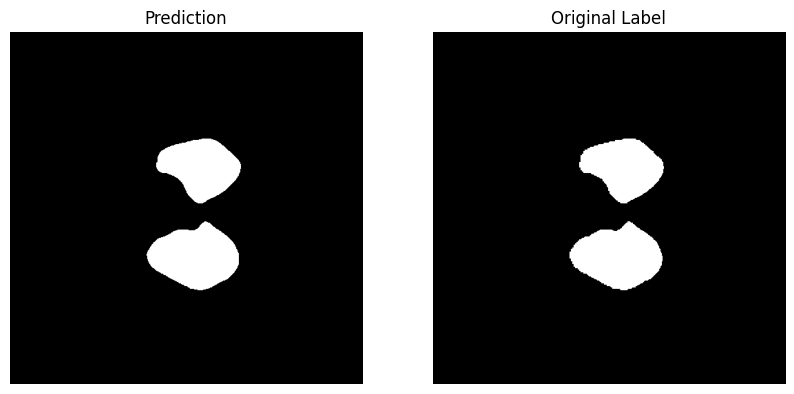

In [35]:
plot_results(res,lab,10,5)

DiceLoss Function for using as Loss

In [36]:
class DiceLoss(torch.nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)
        preds = preds.view(-1)
        targets = targets.view(-1)

        intersection = (preds * targets).sum()
        dice_coefficient = (2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth)

        return 1. - dice_coefficient


### ResUnet with Resnet18 and Dice loss as loss function
* The same ResNet18 architecture is used.
* The Dice loss function is employed here. Dice loss is particularly suited for data with imbalanced classes, which is often the case in medical image segmentation and wanted to try since we evaluate with the same.
* Using Dice loss allows us to directly optimize for the metric we use for evaluation, potentially leading to better segmentation performance on our lung CT scans.

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_8339/2511421886.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
/tmp/ipykernel_8339/2511421886.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
 10%|█         | 1/10 [02:38<23:45, 158.42s/it]

Epoch [1/10], Train Loss: 0.0060, Train Dice Score: 0.9754, Validation Loss: 0.1444, Validation Dice Score: 0.9099


 20%|██        | 2/10 [05:18<21:14, 159.36s/it]

Epoch [2/10], Train Loss: 0.0059, Train Dice Score: 0.9753, Validation Loss: 0.1119, Validation Dice Score: 0.9438


 30%|███       | 3/10 [08:00<18:43, 160.55s/it]

Epoch [3/10], Train Loss: 0.0048, Train Dice Score: 0.9824, Validation Loss: 0.1102, Validation Dice Score: 0.9460


 40%|████      | 4/10 [10:39<15:59, 159.87s/it]

Epoch [4/10], Train Loss: 0.0046, Train Dice Score: 0.9836, Validation Loss: 0.1057, Validation Dice Score: 0.9462


 50%|█████     | 5/10 [13:19<13:19, 159.95s/it]

Epoch [5/10], Train Loss: 0.0044, Train Dice Score: 0.9840, Validation Loss: 0.1062, Validation Dice Score: 0.9428


 60%|██████    | 6/10 [15:59<10:39, 159.98s/it]

Epoch [6/10], Train Loss: 0.0046, Train Dice Score: 0.9801, Validation Loss: 0.0987, Validation Dice Score: 0.9517


 70%|███████   | 7/10 [18:37<07:58, 159.48s/it]

Epoch [7/10], Train Loss: 0.0044, Train Dice Score: 0.9830, Validation Loss: 0.0986, Validation Dice Score: 0.9623


 80%|████████  | 8/10 [21:16<05:18, 159.08s/it]

Epoch [8/10], Train Loss: 0.0051, Train Dice Score: 0.9812, Validation Loss: 0.1190, Validation Dice Score: 0.9377


 90%|█████████ | 9/10 [23:54<02:38, 158.87s/it]

Epoch [9/10], Train Loss: 0.0058, Train Dice Score: 0.9739, Validation Loss: 0.1060, Validation Dice Score: 0.9542


100%|██████████| 10/10 [26:32<00:00, 159.24s/it]

Epoch [10/10], Train Loss: 0.0044, Train Dice Score: 0.9827, Validation Loss: 0.1038, Validation Dice Score: 0.9485


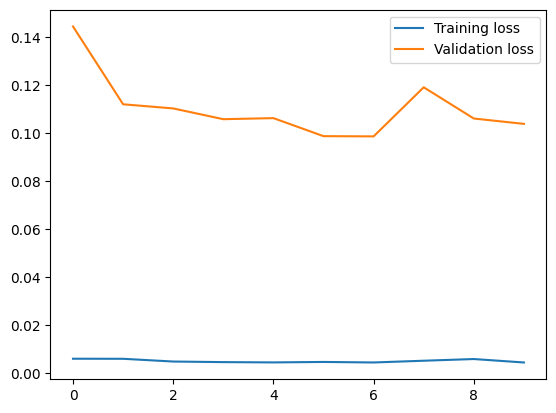

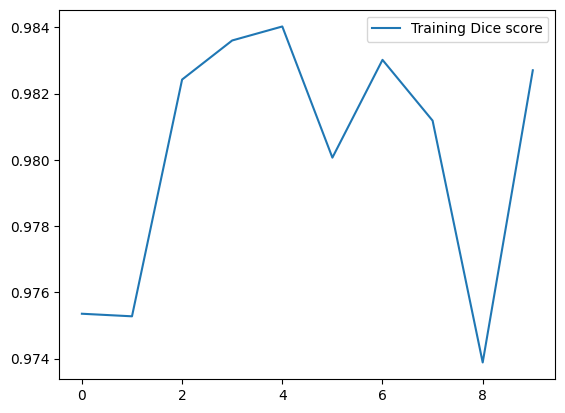

In [48]:
num_epochs = 10
loss_criterion = DiceLoss()
dice_score_function = dice_score
prefix = 'unet_'+str(20)+'_resnet18_dice_1e-4_'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

train_losses, train_dice_scores, valid_losses, valid_dice_scores = train_model(model, num_epochs, train_loader, valid_loader, device, loss_criterion, optimizer, dice_score_function, prefix+ 'best_model.pth', prefix+'train_loss.txt',prefix+ 'valid_loss.txt', prefix+'dice_scores.txt')

plot_loss(prefix+'train_loss.txt', prefix+'valid_loss.txt')
plot_dice(prefix+'dice_scores.txt')

model_path = prefix+ 'best_model.pth'  # Replace with your saved model's path
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)


In [49]:
model_path = 'unet_20_resnet18_dice_1e-4_best_model.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)

res, lab, dice = eval_model(model, test_loader, device)

  0%|          | 0/89 [00:00<?, ?it/s]/tmp/ipykernel_8339/2511421886.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
/tmp/ipykernel_8339/2511421886.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
100%|██████████| 89/89 [00:06<00:00, 13.26it/s]

Average Test Dice Score: 0.9517


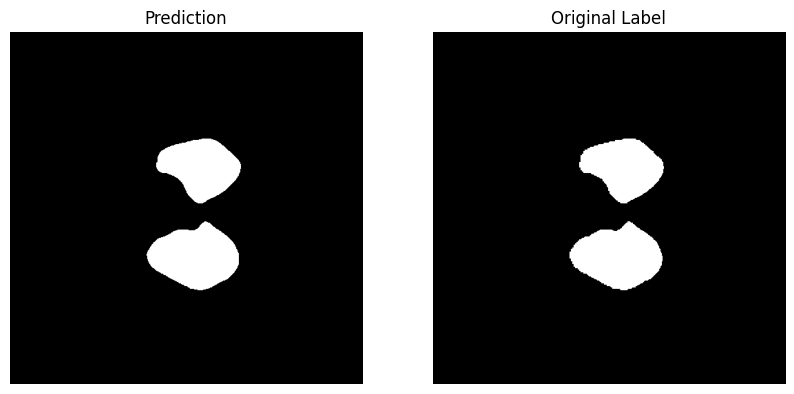

In [40]:
plot_results(res,lab,10,5)

### ResUnet with Resnet18 and Focal Loss as loss function
* Continuing with ResNet18 for its efficiency.
* FocalLoss is used, which is designed to address class imbalance by focusing more on hard-to-classify examples.
* FocalLoss is particularly useful in situations where there is a significant imbalance between the foreground and background classes, which is common in segmentation tasks like ours.

In [41]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss) 
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss


  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_8339/2511421886.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
/tmp/ipykernel_8339/2511421886.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
 10%|█         | 1/10 [02:39<23:57, 159.69s/it]

Epoch [1/10], Train Loss: 0.0071, Train Dice Score: 0.8614, Validation Loss: 0.0014, Validation Dice Score: 0.9162


 20%|██        | 2/10 [05:19<21:16, 159.57s/it]

Epoch [2/10], Train Loss: 0.0010, Train Dice Score: 0.9552, Validation Loss: 0.0013, Validation Dice Score: 0.9490


 30%|███       | 3/10 [07:58<18:35, 159.30s/it]

Epoch [3/10], Train Loss: 0.0005, Train Dice Score: 0.9701, Validation Loss: 0.0014, Validation Dice Score: 0.9552


 40%|████      | 4/10 [10:37<15:56, 159.44s/it]

Epoch [4/10], Train Loss: 0.0008, Train Dice Score: 0.9432, Validation Loss: 0.0006, Validation Dice Score: 0.9416


 50%|█████     | 5/10 [13:16<13:16, 159.29s/it]

Epoch [5/10], Train Loss: 0.0004, Train Dice Score: 0.9606, Validation Loss: 0.0009, Validation Dice Score: 0.9414


 60%|██████    | 6/10 [15:55<10:36, 159.21s/it]

Epoch [6/10], Train Loss: 0.0003, Train Dice Score: 0.9748, Validation Loss: 0.0008, Validation Dice Score: 0.9312


 70%|███████   | 7/10 [18:35<07:57, 159.32s/it]

Epoch [7/10], Train Loss: 0.0003, Train Dice Score: 0.9716, Validation Loss: 0.0005, Validation Dice Score: 0.8660


 80%|████████  | 8/10 [21:14<05:18, 159.24s/it]

Epoch [8/10], Train Loss: 0.0004, Train Dice Score: 0.9670, Validation Loss: 0.0006, Validation Dice Score: 0.9392


 90%|█████████ | 9/10 [23:53<02:39, 159.22s/it]

Epoch [9/10], Train Loss: 0.0003, Train Dice Score: 0.9788, Validation Loss: 0.0007, Validation Dice Score: 0.9389


100%|██████████| 10/10 [26:32<00:00, 159.26s/it]

Epoch [10/10], Train Loss: 0.0003, Train Dice Score: 0.9780, Validation Loss: 0.0016, Validation Dice Score: 0.9323


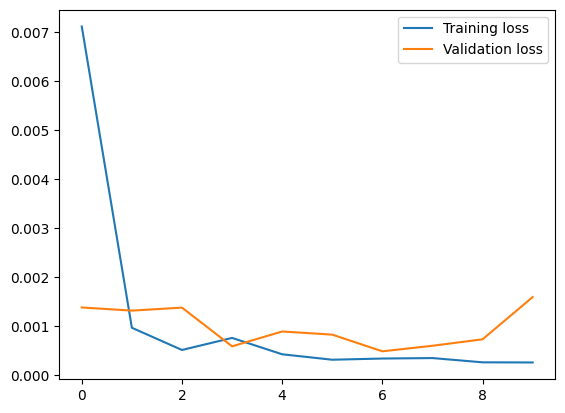

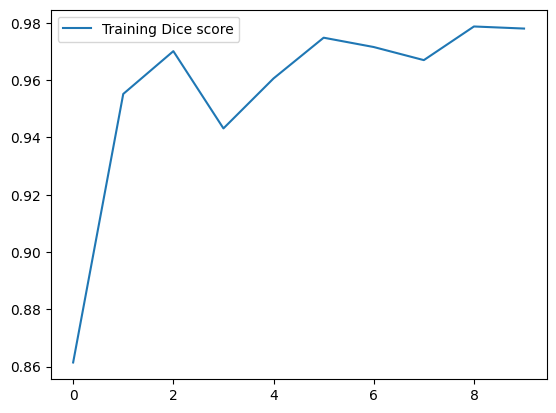

In [42]:
num_epochs = 10
model = smp.Unet(
    encoder_name="resnet18",      
    encoder_weights="imagenet",  
    in_channels=1,                
    classes=1                   
)
loss_criterion = FocalLoss(alpha=0.25, gamma=2.0)
dice_score_function = dice_score
prefix = 'unet_'+str(num_epochs)+'_resnet18_focal_1e-4_'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

train_losses, train_dice_scores, valid_losses, valid_dice_scores = train_model(model, num_epochs, train_loader, valid_loader, device, loss_criterion, optimizer, dice_score_function, prefix+ 'best_model.pth', prefix+'train_loss.txt',prefix+ 'valid_loss.txt', prefix+'dice_scores.txt')

plot_loss(prefix+'train_loss.txt', prefix+'valid_loss.txt')
plot_dice(prefix+'dice_scores.txt')

model_path = prefix+ 'best_model.pth' 
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)

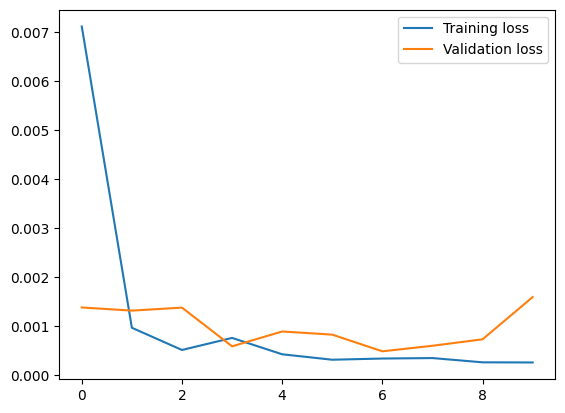

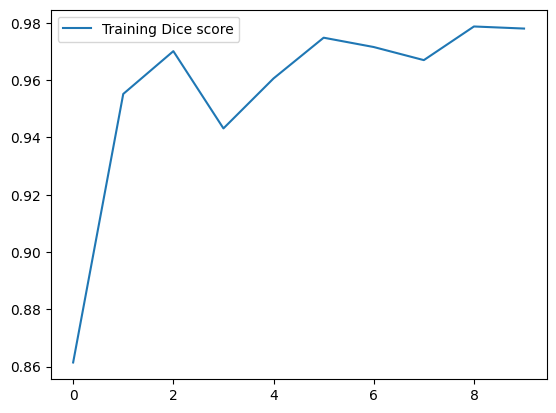

In [43]:
plot_loss(prefix+'train_loss.txt', prefix+'valid_loss.txt')
plot_dice(prefix+'dice_scores.txt')

In [44]:
model_path = prefix+ 'best_model.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
res, lab, dice = eval_model(model, test_loader, device)

  0%|          | 0/89 [00:00<?, ?it/s]/tmp/ipykernel_8339/2511421886.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
/tmp/ipykernel_8339/2511421886.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
100%|██████████| 89/89 [00:07<00:00, 11.72it/s]

Average Test Dice Score: 0.8559


In [ ]:
plot_results(res,lab,10,5)

## Comparison with State-of-the-Art Tool: Lungmask
* Lungmask is a widely recognized tool in the medical imaging field, known for its robust lung segmentation capabilities.
* Lungmask utilizes the U-net(R231) architecture. This architecture is a variant of the standard U-Net, which is highly effective in medical image segmentation tasks.
* The model was trained on a large and diverse dataset encompassing a broad range of visual variability. This diversity ensures its robustness and generalizability across different CT scan images.
* It segments individual slices and accurately extracts the right and left lungs separately. Furthermore, it includes the segmentation of air pockets, tumors, and effusions, providing a comprehensive lung analysis.

### Performance Comparison
Lungmask (U-net(R231)) Dice Score: 0.952

Our Best Model (Res18 BCE) Dice Score: 0.957

In [5]:
import numpy as np
import nibabel as nib
from lungmask import mask
import SimpleITK as sitk
import matplotlib.pyplot as plt
from ipywidgets import interact
import os
import nibabel as nib


In [6]:
def apply_lungmask(input_file_path):
    input_image = sitk.ReadImage(input_file_path)
    segmentation = mask.apply(input_image, force_cpu=True)

    return segmentation


In [7]:
images = [os.path.join("./imagesTr/", file) for file in os.listdir("./imagesTr/")]
labels = [os.path.join("./test/", file) for file in os.listdir("./test/")]
images.sort()
labels.sort()


In [8]:
ll , ul = 36,40  
labs = []
labs2 = []
for i in range(ll,ul):
    file_path = labels[i]
    nii_data = nib.load(file_path)
    nii_data = nii_data.get_fdata()
    labs2.append(nii_data)
    for i in np.transpose(nii_data, (2, 0, 1)):
        labs.append(i)

In [9]:
ll , ul = 36,40 
results = []
for i in range(ll,ul):
    file_path = images[i]
    segmentation_result = apply_lungmask(file_path)
    results.append(segmentation_result)

 90%|█████████ | 8/8.85 [00:39<00:04,  5.05s/it]/home2/rhuthik.p/miniconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
102%|██████████| 9/8.85 [00:43<00:00,  4.87s/it]

lungmask 2023-12-18 05:28:19 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 80.57it/s]
103%|██████████| 6/5.85 [00:29<00:00,  4.84s/it]

lungmask 2023-12-18 05:28:52 Postprocessing



100%|██████████| 10/10 [00:00<00:00, 158.69it/s]
102%|██████████| 24/23.55 [01:54<-1:59:58,  4.76s/it]

lungmask 2023-12-18 05:30:54 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 176.31it/s]
101%|██████████| 24/23.85 [02:01<00:00,  5.08s/it]

lungmask 2023-12-18 05:33:07 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 232.89it/s]


In [10]:
flattened_list = []
for item in results:
    for slice in item:
        flattened_list.append(slice)

In [11]:
res = flattened_list
lab = labs
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display

In [12]:
concatenated_res = np.array(res)
concatenated_lab = np.array(lab)
def show_images(index):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(concatenated_lab[index], cmap='gray')
    axs[0].set_title('Label')
    axs[0].axis('off')

    axs[1].imshow(concatenated_res[index].T>0.5, cmap='gray')
    axs[1].set_title('Result')
    axs[1].axis('off')

    plt.show()

n = concatenated_lab.shape[0] 
slider = widgets.IntSlider(value=0, min=0, max=n-1, step=1, description='Index')

widgets.interactive(show_images, index=slider)

interactive(children=(IntSlider(value=0, description='Index', max=1241), Output()), _dom_classes=('widget-inte…

In [13]:
scores = []
for i in range(len(concatenated_res)):
    scores.append(dice_score(torch.tensor(concatenated_res[i].T).unsqueeze(0).unsqueeze(0),torch.tensor(concatenated_lab[i]).unsqueeze(0).unsqueeze(0)))
np.mean(scores)

0.9526719610963972